# Tweet Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/tweet/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library

In [2]:
import nltk
import string
import gensim
import pickle
import numpy as np
import pandas as pd
import timeit
from gensim import models, corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm.notebook import tnrange


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Sentiment Analysis

In [3]:
df = pd.read_csv(base_path+"dataClean.csv")
df = df.drop(['Unnamed: 0'], axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Text
0,2020-01-22,business we talked about investors reaction in...
1,2020-01-22,let s blow this joint anywhere this doesn t exist
2,2020-01-22,the us has reported its first case of the dead...
3,2020-01-22,update on from china people have died and case...
4,2020-01-22,and here i was thinking the was how i was gonn...
...,...,...
553391,2020-05-05,why in god s name are assemblyline employees p...
553392,2020-05-05,us tests per day day average february march ma...
553393,2020-05-05,today north central bronx hospital cut the rib...
553394,2020-05-05,china s lately launched nationwide blockchain ...


In [4]:
senti = SentimentIntensityAnalyzer()
def get_sentiment_score(review):
    try:
        compound_score = senti.polarity_scores(review)['compound']
        return compound_score
    except:
        return "error"
    
def get_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
start = timeit.default_timer()
df["Sentiment_score"] = df["Text"].apply(get_sentiment_score)
df["Polarity"] = df["Sentiment_score"].apply(get_sentiment)
stop = timeit.default_timer()
print('Time: ', stop - start)


Time:  158.56596332400022


In [5]:
print('Number of positive tweet:',len(df[df['Polarity']=='Positive']))
print('Number of negative tweet:',len(df[df['Polarity']=='Negative']))
print('Number of neutral tweet:',len(df[df['Polarity']=='Neutral']))

Number of positive tweet: 225753
Number of negative tweet: 210681
Number of neutral tweet: 116962


In [6]:
df_temp = df.groupby(['Date','Polarity']).count().unstack()
df_temp = df_temp["Text"].reset_index()
df_temp['Positive_rate'] = df_temp['Positive']*100.0/(df_temp['Positive']+df_temp['Negative']+df_temp['Neutral'])
df_temp['Neutral_rate'] = df_temp['Neutral']*100.0/(df_temp['Positive']+df_temp['Negative']+df_temp['Neutral'])
df_temp['Negative_rate'] = df_temp['Negative']*100.0/(df_temp['Positive']+df_temp['Negative']+df_temp['Neutral'])
df_temp['Count'] = df_temp['Positive']+df_temp['Negative']+df_temp['Neutral']
df_temp

Polarity,Date,Negative,Neutral,Positive,Positive_rate,Neutral_rate,Negative_rate,Count
0,2020-01-22,13,15,4,12.500000,46.875000,40.625000,32
1,2020-01-23,14,11,12,32.432432,29.729730,37.837838,37
2,2020-01-24,28,23,15,22.727273,34.848485,42.424242,66
3,2020-01-25,21,16,24,39.344262,26.229508,34.426230,61
4,2020-01-26,36,17,16,23.188406,24.637681,52.173913,69
...,...,...,...,...,...,...,...,...
99,2020-05-01,5843,3283,6699,42.331754,20.745656,36.922591,15825
100,2020-05-02,3988,2193,3939,38.922925,21.669960,39.407115,10120
101,2020-05-03,3613,2012,3513,38.443861,22.017947,39.538192,9138
102,2020-05-04,3952,2193,4658,43.117653,20.299917,36.582431,10803


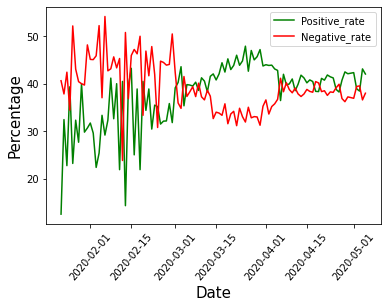

In [7]:
plt.plot('Date', 'Positive_rate', data=df_temp, color='green')
plt.plot('Date', 'Negative_rate', data=df_temp, color='red')
plt.xticks(rotation=50)
plt.ylabel('Percentage', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.show()

In [0]:
df.to_csv(base_path+"sentiment_result.csv")

## Topic modeling

### Pre-processing

In [9]:
nltk.download('wordnet')
stop = gensim.parsing.preprocessing.STOPWORDS
stop_extent = ['ok','let','hey']
punc = set(string.punctuation)
wn = WordNetLemmatizer()

def clean(doc):
    # remove punctuation
    doc = [ch for ch in doc if ch not in punc]
    doc = "".join(doc)
    
    doc = doc.split()
    # remove stop words
    doc = [word for word in doc if word not in stop]
    doc = [word for word in doc if word not in stop_extent]
    # bigram
    doc = bigram_mod[doc]
    # lemmatize
    doc = [wn.lemmatize(word) for word in doc]
    # remove single char
    doc = [word for word in doc if len(word) >1]
    return doc

start = timeit.default_timer()
doc_full = df['Text'].to_list()
# bigram mode
bigram = gensim.models.Phrases([i.split() for i in doc_full], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
# clean data
doc_clean = [clean(doc) for doc in doc_full]
stop = timeit.default_timer()
print('Time: ', stop - start)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Time:  129.354234938


In [0]:
# save
with open(base_path+"doc_clean.pkl", "wb") as fp: 
    pickle.dump(doc_clean, fp)

### Modeling

In [0]:
# load
doc_clean = []
with open(base_path+"doc_clean.pkl", 'rb') as fp:
    doc_clean = pickle.load(fp)

In [11]:
doc_clean_small = doc_clean[:200000]
dictionary = corpora.Dictionary(doc_clean_small)
dictionary.filter_extremes(no_below=5)
corpus = [dictionary.doc2bow(doc) for doc in doc_clean_small]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda_models = []
for num_topics in tnrange(20,30):
    print ('No. topics: {}'.format(num_topics))
    ldamodel = models.ldamulticore.LdaMulticore(corpus=corpus_tfidf, 
                                                num_topics=num_topics, 
                                                id2word=dictionary,
                                                workers=6,
                                                passes=20)
    perplexity = ldamodel.log_perplexity(corpus_tfidf)
    print('Perplexity: {}'.format(perplexity))
    coherence_model_lda = CoherenceModel(model=ldamodel, 
                                        texts=doc_clean_small, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
    score = coherence_model_lda.get_coherence()
    print('Score: {}'.format(score))
    lda_models.append(ldamodel)

No. topics: 20
Perplexity: -10.584885184541692
Score: 0.44120446174403744
No. topics: 21
Perplexity: -10.652254924964044
Score: 0.42743932731489387
No. topics: 22
Perplexity: -10.713743125734824
Score: 0.42608636491470336
No. topics: 23
Perplexity: -10.749066393660355
Score: 0.40945042225355244
No. topics: 24
Perplexity: -10.79381737000039
Score: 0.4095813894058131
No. topics: 25
Perplexity: -10.845090928579033
Score: 0.42669408460735697
No. topics: 26
Perplexity: -10.921729828461192
Score: 0.4126999913562725
No. topics: 27
Perplexity: -10.933590998591002
Score: 0.4560466548507642
No. topics: 28
Perplexity: -10.9712591598644
Score: 0.4115784950762584
No. topics: 29
Perplexity: -11.024811258383178
Score: 0.4498601926311814



In [0]:
ldamodel = lda_models[7]

In [0]:
# save ldamodel
with open(base_path+"lda_model.pkl", "wb") as fp: 
    pickle.dump(ldamodel, fp)

In [0]:
# load ldamodel
ldamodel = None
with open(base_path+"lda_model.pkl", "rb") as fp: 
    ldamodel = pickle.load(fp)

In [14]:
for idx, topic in ldamodel.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))

Topic: 0 
Words: 0.009*"hand" + 0.007*"wash" + 0.005*"tw" + 0.004*"prisoner" + 0.004*"clinical_trial" + 0.004*"officer" + 0.004*"writes" + 0.003*"water" + 0.003*"changing" + 0.003*"soap"
Topic: 1 
Words: 0.009*"india" + 0.006*"warned" + 0.006*"trump" + 0.005*"hart_island" + 0.005*"oil" + 0.005*"loved_one" + 0.005*"latino" + 0.005*"nyt" + 0.005*"forever" + 0.004*"changed"
Topic: 2 
Words: 0.008*"resource" + 0.007*"join" + 0.007*"pandemic" + 0.006*"crisis" + 0.006*"student" + 0.006*"help" + 0.005*"free" + 0.005*"curve" + 0.005*"webinar" + 0.005*"health"
Topic: 3 
Words: 0.009*"like" + 0.008*"people" + 0.007*"know" + 0.007*"shit" + 0.006*"got" + 0.006*"thing" + 0.006*"going" + 0.005*"gonna" + 0.005*"day" + 0.005*"think"
Topic: 4 
Words: 0.008*"dr_fauci" + 0.007*"fauci" + 0.007*"florida" + 0.006*"texas" + 0.005*"plasma" + 0.005*"poverty" + 0.005*"trump" + 0.004*"saved" + 0.004*"pollution" + 0.004*"laid"
Topic: 5 
Words: 0.012*"stay" + 0.012*"stayhome" + 0.011*"home" + 0.009*"nyc" + 0.008*"

In [42]:
topics = []
for idx, topic in ldamodel.print_topics(-1):
    each_topic = [i.split('*"')[1][:-1] for i in topic.split(' + ')]

    topics.append(', '.join(each_topic))
df_topics = pd.DataFrame(topics,columns=['Topics'])
df_topics.to_csv(base_path+'model_topics.csv')
df_topics

,Topics
0,"hand, wash, tw, prisoner, clinical_trial, offi..."
1,"india, warned, trump, hart_island, oil, loved_..."
2,"resource, join, pandemic, crisis, student, hel..."
3,"like, people, know, shit, got, thing, going, g..."
4,"dr_fauci, fauci, florida, texas, plasma, pover..."
5,"stay, stayhome, home, nyc, safe, igshid, quara..."
6,"relief, worker, fund, help, pandemic, support,..."
7,"tiger, homeless, worker, essential, bronx_zoo,..."
8,"spain, grocery, initiative, threatens, hardest..."
9,"sign, petition, pandemic, trump, intelligence,..."


In [16]:
topic_list = [sorted(ldamodel[dictionary.doc2bow(doc_clean[i])], 
                     key=lambda tup: -1*tup[1])[0][0] for i in tnrange(len(doc_clean))]
df['Topics'] = pd.DataFrame(topic_list,columns=['Topics'])
df

,Date,Text,Sentiment_score,Polarity,Topics
0,2020-01-22,business we talked about investors reaction in...,0.0000,Neutral,2
1,2020-01-22,let s blow this joint anywhere this doesn t exist,0.0000,Neutral,3
2,2020-01-22,the us has reported its first case of the dead...,-0.0258,Negative,14
3,2020-01-22,update on from china people have died and case...,-0.8442,Negative,14
4,2020-01-22,and here i was thinking the was how i was gonn...,-0.6560,Negative,3
...,...,...,...,...,...
553391,2020-05-05,why in god s name are assemblyline employees p...,0.2732,Positive,7
553392,2020-05-05,us tests per day day average february march ma...,0.0000,Neutral,14
553393,2020-05-05,today north central bronx hospital cut the rib...,-0.0258,Negative,17
553394,2020-05-05,china s lately launched nationwide blockchain ...,-0.2732,Negative,15


Polarity,Negative,Neutral,Positive,Positive_rate,Negative_rate,Neutral_rate
Topics,,,,,,
0,3891,3174,3582,0.336433,0.365455,0.298112
1,2483,1604,1662,0.289094,0.431901,0.279005
2,14547,11822,32160,0.549471,0.248543,0.201985
3,25508,7443,26594,0.446620,0.428382,0.124998
4,2814,1545,1626,0.271679,0.470175,0.258145
5,9186,6425,21535,0.579739,0.247294,0.172966
6,14347,5248,24934,0.559950,0.322195,0.117856
7,5163,2822,6211,0.437518,0.363694,0.198788
8,1361,1120,1230,0.331447,0.366748,0.301805


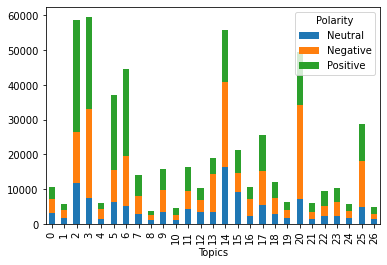

In [41]:
df_topic = df.groupby(['Topics','Polarity'])['Text'].count().unstack()
df_topic["Positive_rate"] = df_topic["Positive"]/(df_topic["Positive"]+df_topic["Negative"]+df_topic["Neutral"])
df_topic["Negative_rate"] = df_topic["Negative"]/(df_topic["Positive"]+df_topic["Negative"]+df_topic["Neutral"])
df_topic["Neutral_rate"] = df_topic["Neutral"]/(df_topic["Positive"]+df_topic["Negative"]+df_topic["Neutral"])
df_topic[["Neutral","Negative","Positive"]].plot(kind='bar',stacked=True)
df_topic